In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas
import cmocean
from copy import copy

df = pandas.read_csv('../data/Gaia-SDSS.csv')
df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
names = df_S.group_id.unique()


/Users/ciaranohare/anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


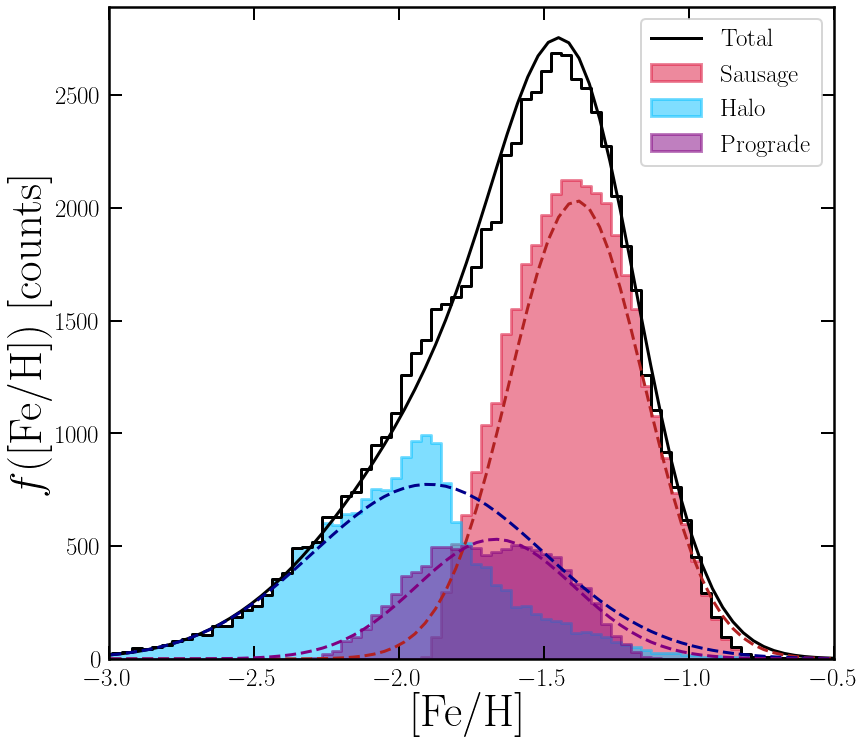

In [3]:
xlab1 = r"[Fe/H]"
ylab1 = r"$f([$Fe/H$])$ [counts]"
fig,ax1 = MySquarePlot(xlab1,ylab1)



nbins = 100
nfine = 100
feh_fine = linspace(-3.5,0,nfine)

h,fehe = histogram(df.feh,bins=nbins)
fehc = (fehe[1:]+fehe[0:-1])/2.0
plt.step(fehc,h,lw=3,color='k')

# Fit data
means_init = zeros(shape=(3,4))
means_init[0,:] = array([0.0,0.0,0.0,-1.4]) # Sausage
means_init[1,:] = array([0.0,0.0,0.0,-2.0]) # Halo
means_init[2,:] = array([0.0,126.0,0.0,-1.8]) # Halo
weights_init = array([0.5,0.34,0.16])
covariance_type = 'full'
data = array([df.GalRVel,df.GalphiVel,df.GalzVel,df.feh]).T
clf = mixture.GaussianMixture(n_components=3, covariance_type=covariance_type,
                              weights_init=weights_init,means_init=means_init,tol=1e-12,reg_covar=1e-8,max_iter=1000)
clf.fit(data)
Ps = clf.predict_proba(data)
meens = clf.means_
covs = clf.covariances_
ws = clf.weights_
eta = ws[0]

Ps = clf.predict_proba(data)
imod = argmax(Ps,axis=1)
df1 = df.loc[imod==0]
df2 = df.loc[imod==1]
df3 = df.loc[imod==2]
feh1 = (df1.feh).as_matrix()
feh2 = (df2.feh).as_matrix()
feh3 = (df3.feh).as_matrix()

h1,_ = histogram(feh1,bins=fehe)
h2,_ = histogram(feh2,bins=fehe)
h3,_ = histogram(feh3,bins=fehe)
plt.fill_between(fehc,h1,lw=3,alpha=0.5,facecolor='Crimson',edgecolor='Crimson',step='pre',label='Sausage')
plt.fill_between(fehc,h2,lw=3,alpha=0.5,facecolor='deepskyblue',edgecolor='deepskyblue',step='pre',label='Halo')
plt.fill_between(fehc,h3,lw=3,alpha=0.5,facecolor='purple',edgecolor='purple',step='pre',label='Prograde')


# Analytic models for metallicity
N = sum(h)*(feh_fine[2]-feh_fine[1])

mu = meens[0,3]
sigsq = covs[0,3,3]
f0 = (1.0/sqrt(2*pi*sigsq))*exp(-(feh_fine-mu)**2.0/(2*sigsq))
f0 /= trapz(f0,feh_fine)

mu = meens[1,3]
sigsq = covs[1,3,3]
f1 = (1.0/sqrt(2*pi*sigsq))*exp(-(feh_fine-mu)**2.0/(2*sigsq))
f1 /= trapz(f1,feh_fine)

mu = meens[2,3]
sigsq = covs[2,3,3]
f2 = (1.0/sqrt(2*pi*sigsq))*exp(-(feh_fine-mu)**2.0/(2*sigsq))
f2 /= trapz(f2,feh_fine)


plt.plot(feh_fine,N*ws[0]*f0+N*ws[1]*f1+N*ws[2]*f2,'k-',lw=3,label='Total')
plt.plot(feh_fine,N*ws[0]*f0,'k--',lw=3,color='Firebrick')
plt.plot(feh_fine,N*ws[1]*f1,'k--',lw=3,color='Darkblue')
plt.plot(feh_fine,N*ws[2]*f2,'k--',lw=3,color='Purple')

leg = plt.legend()
leg.get_frame().set_linewidth(2)

ax1.set_ylim(bottom=0.0)
ax1.set_xlim([-3.0,-0.5])
pltname = 'feh-SausageHaloPrograde'
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')  



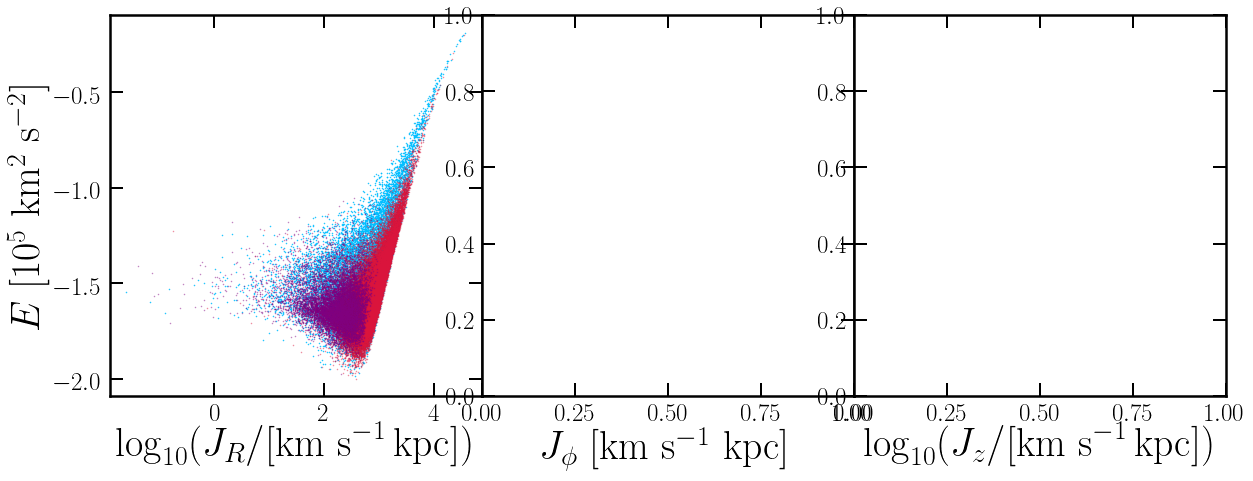

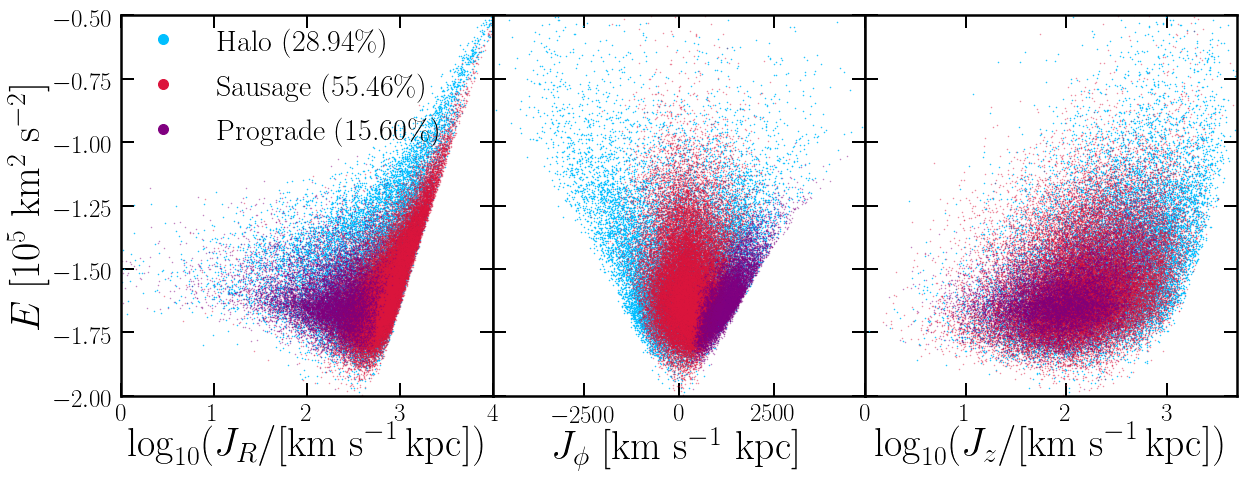

In [5]:
rlab = r'$\log_{10}(J_R/[\textrm{km s}^{-1}\,\textrm{kpc}])$'
plab = '$J_\phi$ [km s$^{-1}$ kpc]'
zlab = r'$\log_{10}(J_z/[\textrm{km s}^{-1}\,\textrm{kpc}])$'
Elab = r'$E$ [$10^5$ km$^2$ s$^{-2}$]'
Emax = -0.5
Emin = -2.0
jrmin = 1.0
jrmax = 10000.0
jpmin = -4900.0
jpmax = 4900.0
jzmin = 1.0
jzmax = 5000.0

fig,ax1,ax2,ax3 = MyTriplePlot(rlab,Elab,plab,'',zlab,'',wspace=0.0,lfs=40)

# choose cut
eta1 = 100*sum(imod==0)/(1.0*shape(df)[0])
eta2 = 100*sum(imod==1)/(1.0*shape(df)[0])
eta3 = 100*sum(imod==2)/(1.0*shape(df)[0])

df1 = df.loc[imod==0]
df2 = df.loc[imod==1]
df3 = df.loc[imod==2]

E1 = (df1.E/1e5).as_matrix()
Jr1 = (df1.JR).as_matrix()
Jp1 = (df1.Jphi).as_matrix()
Jz1 = (df1.Jz).as_matrix()
E2 = (df2.E/1e5).as_matrix()
Jr2 = (df2.JR).as_matrix()
Jp2 = (df2.Jphi).as_matrix()
Jz2 = (df2.Jz).as_matrix()
E3 = (df3.E/1e5).as_matrix()
Jr3 = (df3.JR).as_matrix()
Jp3 = (df3.Jphi).as_matrix()
Jz3 = (df3.Jz).as_matrix()

ax1.plot(log10(Jr2),E2,'.',color='deepskyblue',markersize=1,rasterized=True)
ax1.plot(log10(Jr1),E1,'.',color='crimson',markersize=1,alpha=0.5,rasterized=True)
ax1.plot(log10(Jr3),E3,'.',color='purple',markersize=1,alpha=0.5,rasterized=True)

ax2.plot(Jp2,E2,'.',color='deepskyblue',markersize=1,rasterized=True)
ax2.plot(Jp1,E1,'.',color='crimson',markersize=1,alpha=0.5,rasterized=True)
ax2.plot(Jp3,E3,'.',color='purple',markersize=1,alpha=0.5,rasterized=True)

ax3.plot(log10(Jz2),E2,'.',color='deepskyblue',markersize=1,rasterized=True)
ax3.plot(log10(Jz1),E1,'.',color='crimson',markersize=1,alpha=0.5,rasterized=True)
ax3.plot(log10(Jz3),E3,'.',color='purple',markersize=1,alpha=0.5,rasterized=True)

ax3.plot(-1,100,'.',color='deepskyblue',markersize=20,rasterized=True,label=r'Halo ('+r'{:.2f}'.format(eta2)+'\%) ')
ax3.plot(-1,100,'.',color='crimson',markersize=20,rasterized=True,label=r'Sausage ('+r'{:.2f}'.format(eta1)+'\%) ')
ax3.plot(-1,100,'.',color='purple',markersize=20,rasterized=True,label=r'Prograde ('+r'{:.2f}'.format(eta3)+'\%) ')

plt.legend(fontsize=30,frameon=False,bbox_to_anchor=(-2.0, 1.0), loc=2, borderaxespad=0.)


# # Plot shards
# Examples = names[0:10]
# n_ex = size(Examples)
# for i in range(0,n_ex):
#     namei = Examples[i]
#     Cand = df_S.loc[df_S['group_id'] == namei]
#     Cand1 = df1.loc[around(df1.ra,8).isin(Cand.ra)]
#     Cand2 = df2.loc[around(df2.ra,8).isin(Cand.ra)]
#     e1 = (Cand1.E/1e5).as_matrix()
#     jr1 = (Cand1.iloc[:,icol]).as_matrix()
#     e2 = (Cand2.E/1e5).as_matrix()
#     jr2 = (Cand2.JR).as_matrix()

#     ax1.plot(log10(jr2),e2,'o',color='deepskyblue',markersize=2,markerfacecolor='none')
#     ax1.plot(log10(jr1),e1,'o',color='crimson',markersize=2,markerfacecolor='none')    

ax2.set_yticklabels([])
ax3.set_yticklabels([])

   
ax1.set_ylim([Emin,Emax])
ax2.set_ylim([Emin,Emax])
ax3.set_ylim([Emin,Emax])

ax1.set_xlim([log10(jrmin),log10(jrmax)])
ax2.set_xlim([jpmin,jpmax])
ax3.set_xlim([log10(jzmin),log10(jzmax)])

# Save
pltname = 'Actions-SausageHaloPrograde'
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')  


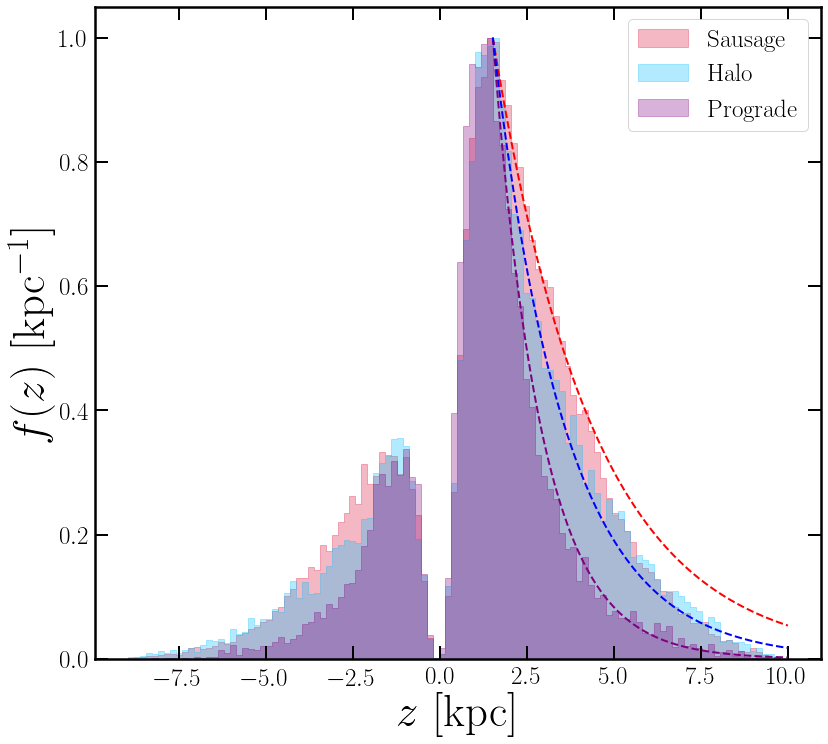

In [37]:
xlab1 = r'$z$ [kpc]'
ylab1 = r'$f(z)$ [kpc$^{-1}$]'
fig,ax1 = MySquarePlot(xlab1,ylab1)

h3,zb = histogram((df3.GalRecZ).as_matrix(),bins='fd',normed=True)
zc = (zb[1:]+zb[0:-1])/2.0
h2,_ = histogram((df2.GalRecZ).as_matrix(),bins=zb,normed=True)
h1,_ = histogram((df1.GalRecZ).as_matrix(),bins=zb,normed=True)

plt.fill_between(zc,h1/amax(h1),color='crimson',alpha=0.3,step='pre',label='Sausage')
plt.fill_between(zc,h2/amax(h2),color='deepskyblue',alpha=0.3,step='pre',label='Halo')
plt.fill_between(zc,h3/amax(h3),color='purple',alpha=0.3,step='pre',label='Prograde')

z0 = zc[argmax(h3)]
zz = linspace(z0,10,100)
R = 8.0
rho3 = exp(-abs(zz-z0)/1.4)
rho2 = exp(-abs(zz-z0)/2.1)
rho1 = exp(-abs(zz-z0)/2.9)

plt.plot(zz,rho3,'--',lw=2,color='purple')
plt.plot(zz,rho1,'--',lw=2,color='red')
plt.plot(zz,rho2,'--',lw=2,color='blue')


ax1.set_ylim(bottom=0.0)
plt.legend()
plt.show()


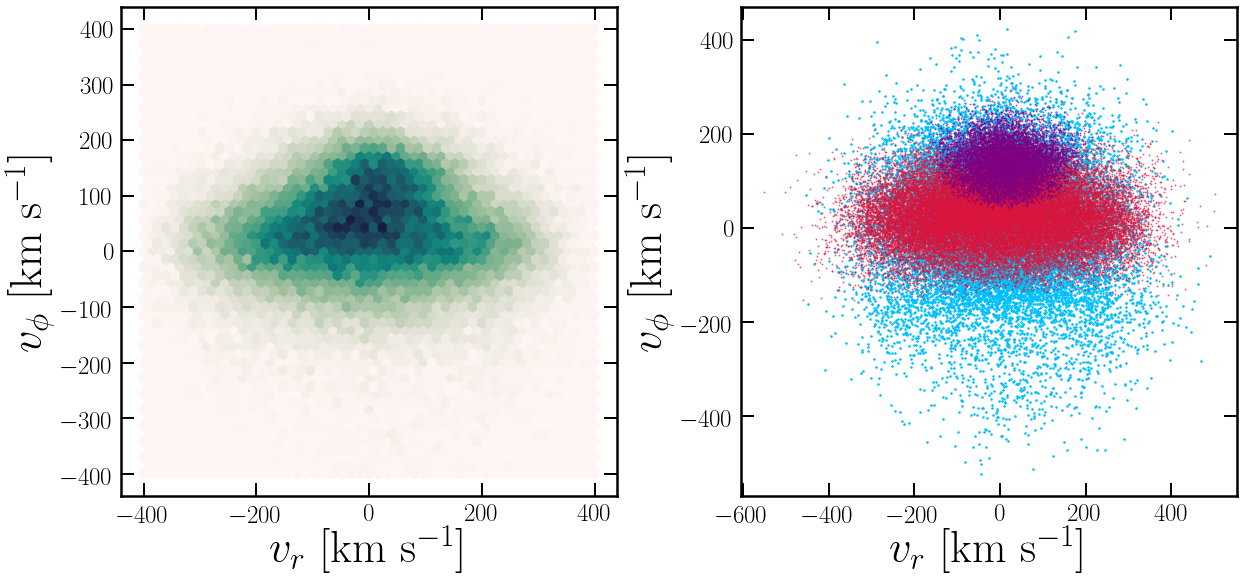

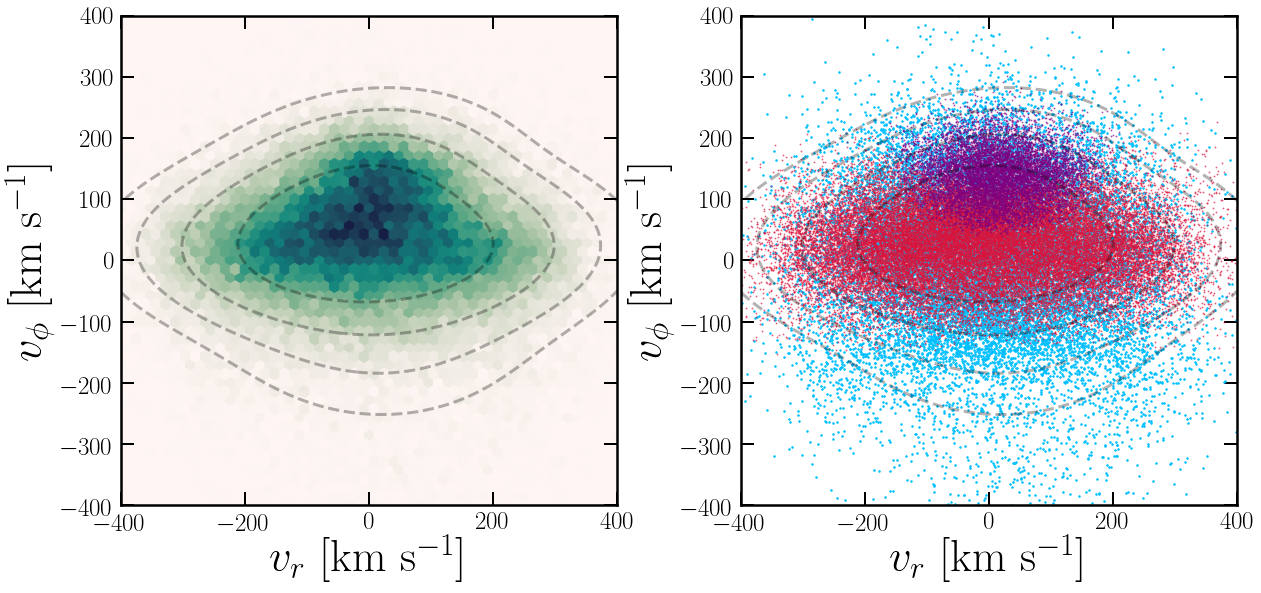

In [93]:
cmap = cmocean.cm.tempo

xlab1 = r'$v_r$ [km s$^{-1}$]'
ylab1 = r'$v_\phi$ [km s$^{-1}$]'
fig,ax1,ax2 = MyDoublePlot(xlab1,ylab1,xlab1,ylab1,size_y=9)

vr1 = (df1.GalRVel).as_matrix()
vp1 = (df1.GalphiVel).as_matrix()

vr2 = (df2.GalRVel).as_matrix()
vp2 = (df2.GalphiVel).as_matrix()

vr3 = (df3.GalRVel).as_matrix()
vp3 = (df3.GalphiVel).as_matrix()

ax2.plot(vr2,vp2,'.',color='deepskyblue',markersize=3,rasterized=True)
ax2.plot(vr1,vp1,'.',color='crimson',markersize=2,alpha=0.5,rasterized=True)
ax2.plot(vr3,vp3,'.',color='purple',markersize=2,alpha=0.5,rasterized=True)



def fv_2D_an(covs,meens,ws,V1,V2,i,j):
    fv = zeros(shape=shape(V1))
    if ndim(covs)>2:
        nm = shape(covs)[0]
    else:
        nm = 1
    for k in range(0,nm): 
        if nm>1:
            U = squeeze(linalg.inv(covs[k,:,:]))
            v10 = meens[k,i]
            v20 = meens[k,j]
            w0 = ws[k]
        else:
            U = squeeze(linalg.inv(covs[:,:]))
            v10 = meens[i]
            v20 = meens[j]
            w0 = ws
        U0 = array([[U[i,i],U[i,j]],[U[j,i],U[j,j]]])
        V = vstack((U[i,:],U[j,:]))    
        V = delete(V, (i,j), axis=1)

        W = delete(U, (i,j), axis=0)
        W = delete(W, (i,j), axis=1)
        Uoff = linalg.multi_dot([V, linalg.inv(W), V.T])
        Ut = U0-Uoff
        V1o = V1-v10
        V2o = V2-v20
        Norm = (1.0/sqrt(2*pi))*sqrt(linalg.det(W))  
        fv += w0*Norm*exp(-0.5*(V1o**2.0*Ut[0,0]+V2o**2.0*Ut[1,1]+2*V1o*V2o*Ut[1,0]))  
    return fv


ax1.hexbin(df.GalRVel,df.GalphiVel,extent=(-400,400,-400,400),gridsize=50,cmap=cmap)

vc1 = linspace(-400,400,100)
vc2 =  linspace(-400,400,100)
VC1,VC2 = meshgrid(vc1,vc2)
Han = fv_2D_an(covs,meens,ws,VC1,VC2,0,1)
levels = [-4,-3,-2,-1,0]
ax1.contour(vc1,vc2,log(Han/amax(Han)),levels=levels,alpha=0.3,colors='k',linewidths=3,zorder=10)
ax2.contour(vc1,vc2,log(Han/amax(Han)),levels=levels,alpha=0.3,colors='k',linewidths=3,zorder=10)

ax1.set_xlim([-400,400])
ax2.set_xlim([-400,400])
ax1.set_ylim([-400,400])
ax2.set_ylim([-400,400])


# Save
pltname = 'vrvphi-SausageHaloPrograde'
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')  


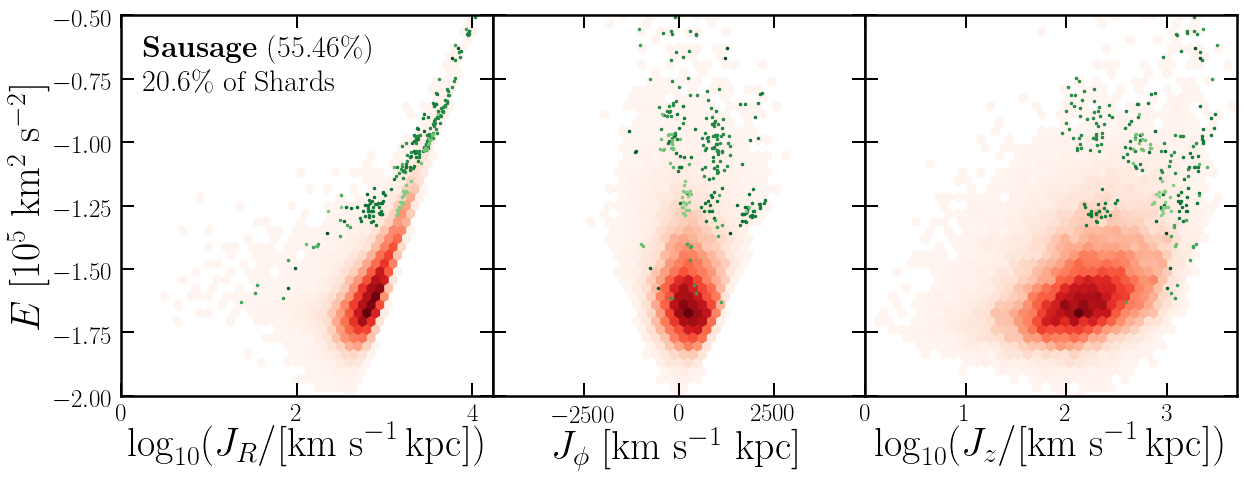

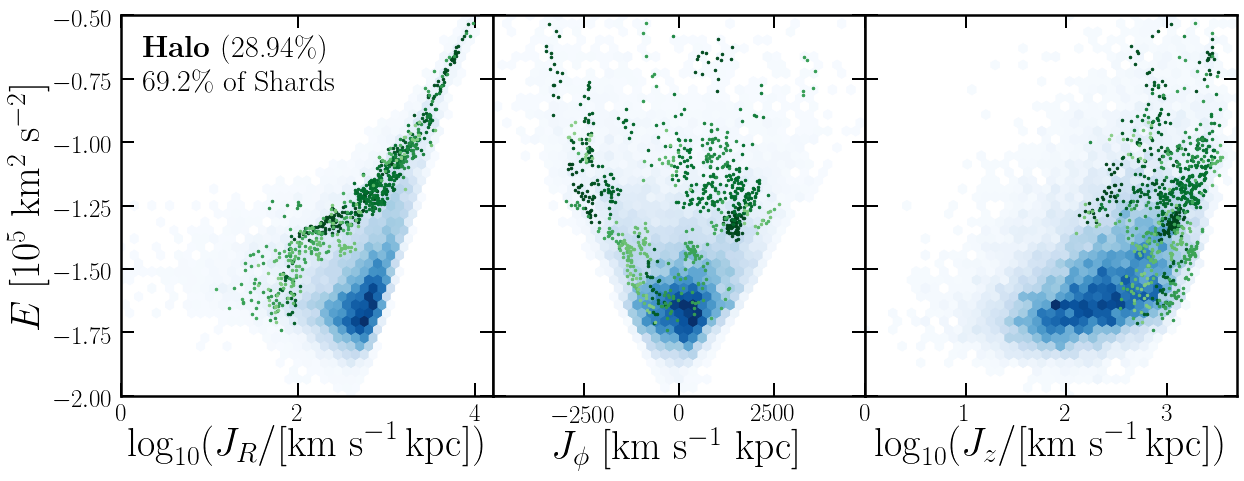

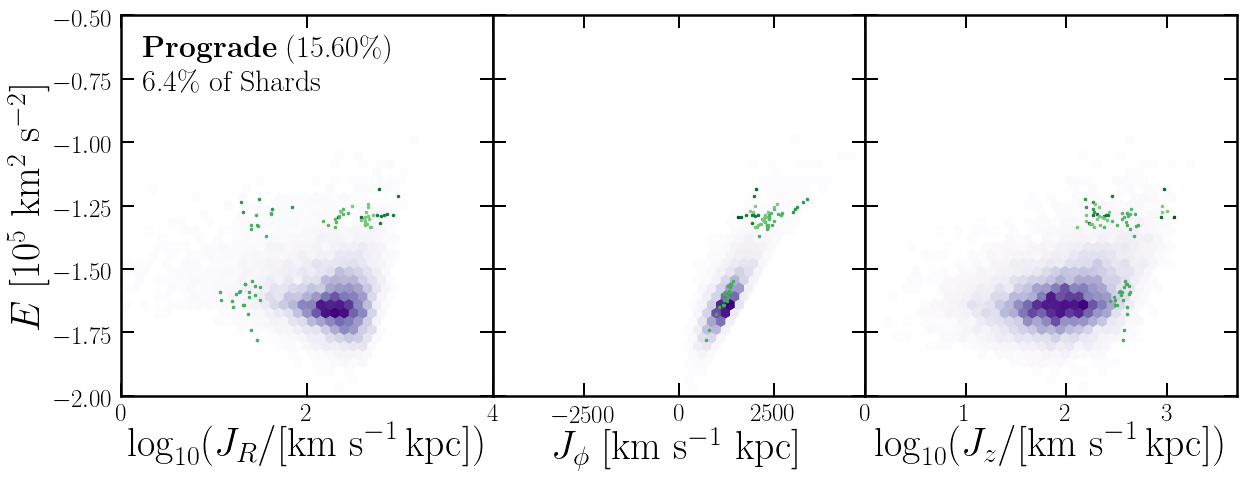

In [159]:
nshards = shape(df_S)[0]


gsize = 40
cmap = cm.Reds
cmap = copy(plt.get_cmap(cmap))
cmap.set_under('white', 1.0)

pltname = 'Actions-3components_Sausage'

fig,ax1,ax2,ax3 = MyTriplePlot(rlab,Elab,plab,'',zlab,'',wspace=0.0,lfs=40)

E1 = (df1.E/1e5).as_matrix()
Jr = (df1.JR).as_matrix()
Jp = (df1.Jphi).as_matrix()
Jz = (df1.Jz).as_matrix()

# Plot halo stars
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)

ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)

ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)

ax2.set_yticklabels([])
ax3.set_yticklabels([])

# Plot shards
Examples = names[:]
n_ex = size(Examples)
col_ex = flipud(cm.Greens(linspace(0,1,n_ex+40)))
points = zeros(shape=(size(x),2))
n1 = 0
for i in range(0,n_ex):
    namei = Examples[i]
    Cand = df_S.loc[df_S['group_id'] == namei]
    Cand0 = df1.loc[around(df1.ra,8).isin(Cand.ra)]
    e0 = (Cand0.E/1e5).as_matrix()
    jr = (Cand0.JR).as_matrix()
    jp = (Cand0.Jphi).as_matrix()
    jz = (Cand0.Jz).as_matrix()
    n1 += shape(Cand0)[0]
    ax1.plot(log10(jr),e0,'.',color=col_ex[i,:],markersize=5)    
    ax2.plot(jp,e0,'.',color=col_ex[i,:],markersize=5)
    ax3.plot(log10(jz),e0,'.',color=col_ex[i,:],markersize=5)
    
ax1.set_ylim([Emin,Emax])
ax2.set_ylim([Emin,Emax])
ax3.set_ylim([Emin,Emax])

# Save
plt.gcf().text(0.14,0.8,r'{\bf Sausage} ('+r'{:.2f}'.format(eta1)+'\%) ',fontsize=30)

fshards1 = (n1/(nshards*1.0))*100
plt.gcf().text(0.14,0.73,r'{:.1f}'.format(fshards1)+'\% of Shards ',fontsize=30)

plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')  

################


gsize = 40
cmap = cm.Blues
cmap = copy(plt.get_cmap(cmap))
cmap.set_under('white', 1.0)

pltname = 'Actions-3components_Halo'

fig,ax1,ax2,ax3 = MyTriplePlot(rlab,Elab,plab,'',zlab,'',wspace=0.0,lfs=40)

E1 = (df2.E/1e5).as_matrix()
Jr = (df2.JR).as_matrix()
Jp = (df2.Jphi).as_matrix()
Jz = (df2.Jz).as_matrix()

# Plot halo stars
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)

ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)

ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)

ax2.set_yticklabels([])
ax3.set_yticklabels([])

# Plot shards
Examples = names[:]
n_ex = size(Examples)
col_ex = flipud(cm.Greens(linspace(0,1,n_ex+40)))
points = zeros(shape=(size(x),2))
n2 = 0
for i in range(0,n_ex):
    namei = Examples[i]
    Cand = df_S.loc[df_S['group_id'] == namei]
    Cand0 = df2.loc[around(df2.ra,8).isin(Cand.ra)]
    e0 = (Cand0.E/1e5).as_matrix()
    jr = (Cand0.JR).as_matrix()
    jp = (Cand0.Jphi).as_matrix()
    jz = (Cand0.Jz).as_matrix()
    n2 += shape(Cand0)[0]
    ax1.plot(log10(jr),e0,'.',color=col_ex[i,:],markersize=5)    
    ax2.plot(jp,e0,'.',color=col_ex[i,:],markersize=5)
    ax3.plot(log10(jz),e0,'.',color=col_ex[i,:],markersize=5)
    
ax1.set_ylim([Emin,Emax])
ax2.set_ylim([Emin,Emax])
ax3.set_ylim([Emin,Emax])

# Save
plt.gcf().text(0.14,0.8,r'{\bf Halo} ('+r'{:.2f}'.format(eta2)+'\%) ',fontsize=30)

fshards2 = (n2/(nshards*1.0))*100
plt.gcf().text(0.14,0.73,r'{:.1f}'.format(fshards2)+'\% of Shards ',fontsize=30)

plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')  



#############



gsize = 40
cmap = cm.Purples
cmap = copy(plt.get_cmap(cmap))
cmap.set_under('white', 1.0)

pltname = 'Actions-3components_Prograde'

fig,ax1,ax2,ax3 = MyTriplePlot(rlab,Elab,plab,'',zlab,'',wspace=0.0,lfs=40)

E1 = (df3.E/1e5).as_matrix()
Jr = (df3.JR).as_matrix()
Jp = (df3.Jphi).as_matrix()
Jz = (df3.Jz).as_matrix()

# Plot halo stars
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax1.hexbin(log10(Jr),E1,extent=(log10(jrmin),log10(jrmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)

ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax2.hexbin(Jp,E1,extent=(jpmin,jpmax,Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)

ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)
ax3.hexbin(log10(Jz),E1,extent=(log10(jzmin),log10(jzmax),Emin,Emax), gridsize=gsize,cmap=cmap,vmin=0.01,linewidths=0.0)

ax2.set_yticklabels([])
ax3.set_yticklabels([])

# Plot shards
Examples = names[:]
n_ex = size(Examples)
col_ex = flipud(cm.Greens(linspace(0,1,n_ex+40)))
points = zeros(shape=(size(x),2))
n3 = 0
for i in range(0,n_ex):
    namei = Examples[i]
    Cand = df_S.loc[df_S['group_id'] == namei]
    Cand0 = df3.loc[around(df3.ra,8).isin(Cand.ra)]
    e0 = (Cand0.E/1e5).as_matrix()
    jr = (Cand0.JR).as_matrix()
    jp = (Cand0.Jphi).as_matrix()
    jz = (Cand0.Jz).as_matrix()
    n3 += shape(Cand0)[0]
    ax1.plot(log10(jr),e0,'.',color=col_ex[i,:],markersize=5)    
    ax2.plot(jp,e0,'.',color=col_ex[i,:],markersize=5)
    ax3.plot(log10(jz),e0,'.',color=col_ex[i,:],markersize=5)
    
ax1.set_ylim([Emin,Emax])
ax2.set_ylim([Emin,Emax])
ax3.set_ylim([Emin,Emax])

# Save
plt.gcf().text(0.14,0.8,r'{\bf Prograde} ('+r'{:.2f}'.format(eta3)+'\%) ',fontsize=30)

fshards3 = (n3/(nshards*1.0))*100
plt.gcf().text(0.14,0.73,r'{:.1f}'.format(fshards3)+'\% of Shards ',fontsize=30)


plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')  

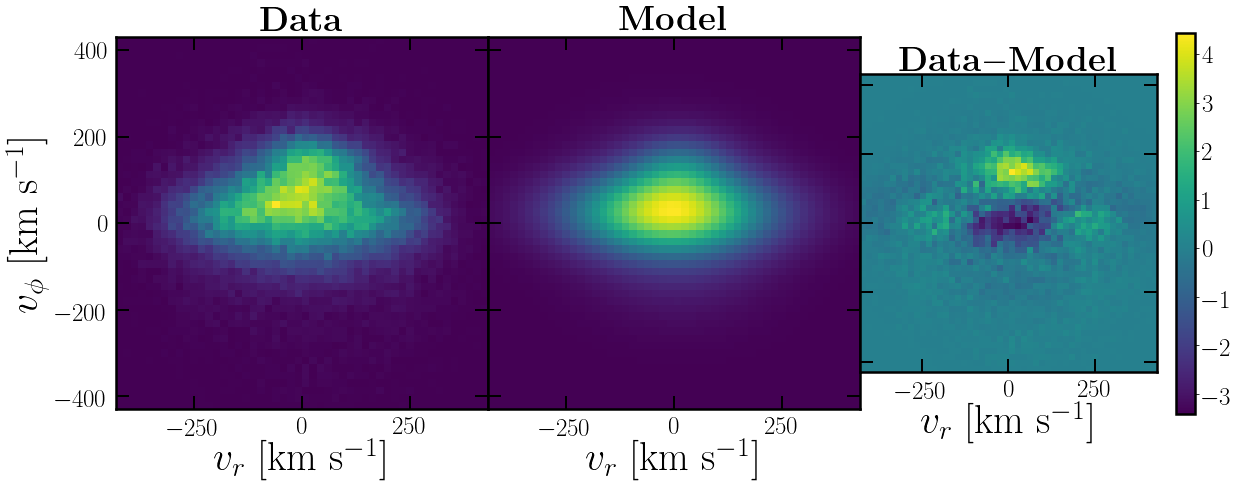

In [155]:
x = df.GalRecX
y = df.GalRecY
z = df.GalRecZ
vx = df.GalU
vy = df.GalV
vz = df.GalW
R = sqrt(x**2.0+y**2.0+z**2.0)
th = arccos(z/R)
ph = arctan2(y,x)
vR = sin(th)*cos(ph)*vx + sin(th)*sin(ph)*vy + cos(ph)*vz
vth = cos(th)*cos(ph)*vx + cos(th)*sin(ph)*vy - sin(ph)*vz
vph = -sin(ph)*vx + cos(ph)*vy

vphi = df.GalphiVel
vrho = df.GalRVel

feh = df.feh
#data = array([vx,vy,vz,feh]).T
data = array([vrho,vphi,vz,feh]).T
#data = array([vR,vph,vth,feh]).T


vrlab = r'$v_r$ [km s$^{-1}$]'
vplab = r'$v_\phi$ [km s$^{-1}$]'
fig,ax1,ax2,ax3 = MyTriplePlot(vrlab,vplab,vrlab,'',vrlab,'',wspace=0.0,lfs=40)

nbins = 50
vmin = -430
vmax = 430

# Fit data
means_init = zeros(shape=(3,4))
means_init[0,:] = array([0.0,0.0,0.0,-1.4]) # Sausage
means_init[1,:] = array([0.0,0.0,0.0,-2.0]) # Halo
means_init[2,:] = array([0.0,126.0,0.0,-1.8]) # Halo
weights_init = array([eta1,eta2,eta3])/100.0

covariance_type = 'full'
clf = mixture.GaussianMixture(n_components=3, covariance_type=covariance_type,
                              weights_init=weights_init,means_init=means_init,tol=1e-12,reg_covar=1e-8,max_iter=10000)
clf.fit(data)
Ps = clf.predict_proba(data)
meens = clf.means_
covs = clf.covariances_
ws = clf.weights_



H,vb1,vb2 = histogram2d(data[:,0],data[:,1],range=((vmin,vmax),(vmin,vmax)),bins=nbins,normed=True)
vc1 = (vb1[1:]+vb1[0:-1])/2
vc2 = (vb2[1:]+vb2[0:-1])/2

VC1,VC2 = meshgrid(vc1,vc2)
Han = fv_2D_an(covs,meens,ws,VC1,VC2,0,1)
Han /= trapz(trapz(Han,vc1),vc2)


ax1.imshow(flipud(H.T),extent=(vmin,vmax,vmin,vmax))
ax2.imshow(flipud(Han),extent=(vmin,vmax,vmin,vmax))
plt.sca(ax3)
plt.imshow(flipud(H.T-Han)*1e6,extent=(vmin,vmax,vmin,vmax))
plt.colorbar()

ax1.set_title(r'{\bf Data}',fontsize=35)
ax2.set_title(r'{\bf Model}',fontsize=35)
ax3.set_title(r'{\bf Data}$-${\bf Model}',fontsize=35)

ax2.set_yticklabels([])
ax3.set_yticklabels([])
#ax2.set_xticks(array([-200,0,200]))

# plt.sca(ax1)
# plt.xticks(rotation=30)
# plt.sca(ax2)
# plt.xticks(rotation=30)
# plt.sca(ax3)
# plt.xticks(rotation=30)
plt.show()

In [142]:
shape(data)

(65406, 4)

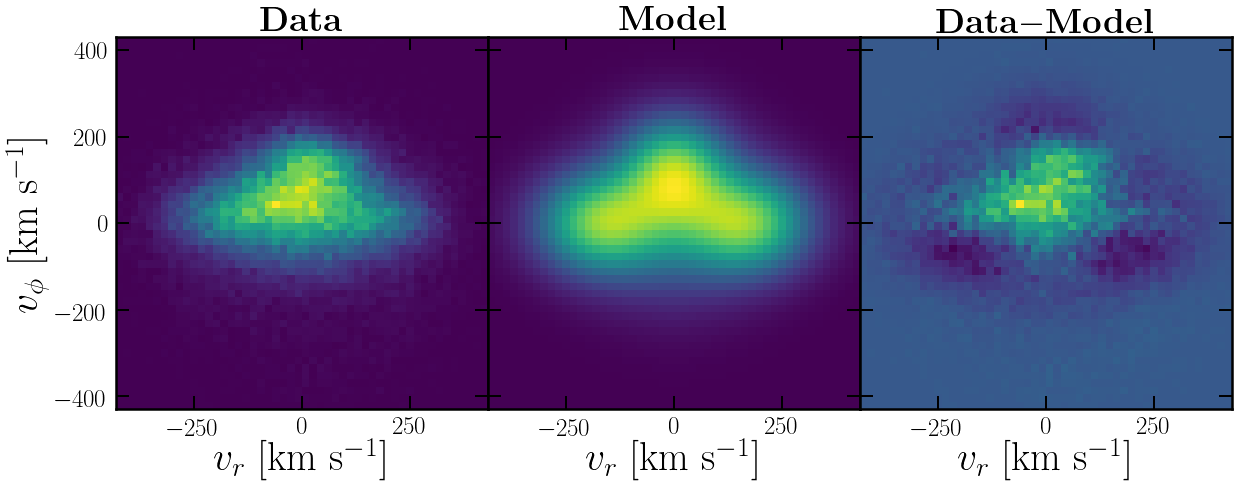

In [114]:

fig,ax1,ax2,ax3 = MyTriplePlot(vrlab,vplab,vrlab,'',vrlab,'',wspace=0.0,lfs=40)

meens = zeros(shape=(4,3))
meens[0,:] = array([176.0,0.0,0.0]) # Sausage
meens[1,:] = array([-176.0,0.0,0.0]) # Halo
meens[2,:] = array([0.0,20.0,0.0]) # Halo
meens[3,:] = array([0.0,126.0,0.0]) # Halo

covs = zeros(shape=(4,3,3))
covs[0,:,:] = array([[100.0,0.0,0.0],[0.0,80.0,0.0],[0.0,0.0,80.0]])
covs[1,:,:] = array([[100.0,0.0,0.0],[0.0,80.0,0.0],[0.0,0.0,80.0]])
covs[2,:,:] = array([[130.0,0.0,0.0],[0.0,130.0,0.0],[0.0,0.0,130.0]])
covs[3,:,:] = array([[80.0,0.0,0.0],[0.0,80.0,0.0],[0.0,0.0,80.0]])
covs = covs**2.0

ws = array([0.3,0.3,0.25,0.25])


VC1,VC2 = meshgrid(vc1,vc2)
Han = fv_2D_an(covs,meens,ws,VC1,VC2,0,1)
Han /= trapz(trapz(Han,vc1),vc2)


ax1.imshow(flipud(H.T),extent=(vmin,vmax,vmin,vmax))
ax2.imshow(flipud(Han),extent=(vmin,vmax,vmin,vmax))
ax3.imshow(flipud(H.T-Han)*1e6,extent=(vmin,vmax,vmin,vmax))

ax1.set_title(r'{\bf Data}',fontsize=35)
ax2.set_title(r'{\bf Model}',fontsize=35)
ax3.set_title(r'{\bf Data}$-${\bf Model}',fontsize=35)

ax2.set_yticklabels([])
ax3.set_yticklabels([])
#ax2.set_xticks(array([-200,0,200]))

# plt.sca(ax1)
# plt.xticks(rotation=30)
# plt.sca(ax2)
# plt.xticks(rotation=30)
# plt.sca(ax3)
# plt.xticks(rotation=30)
plt.show()

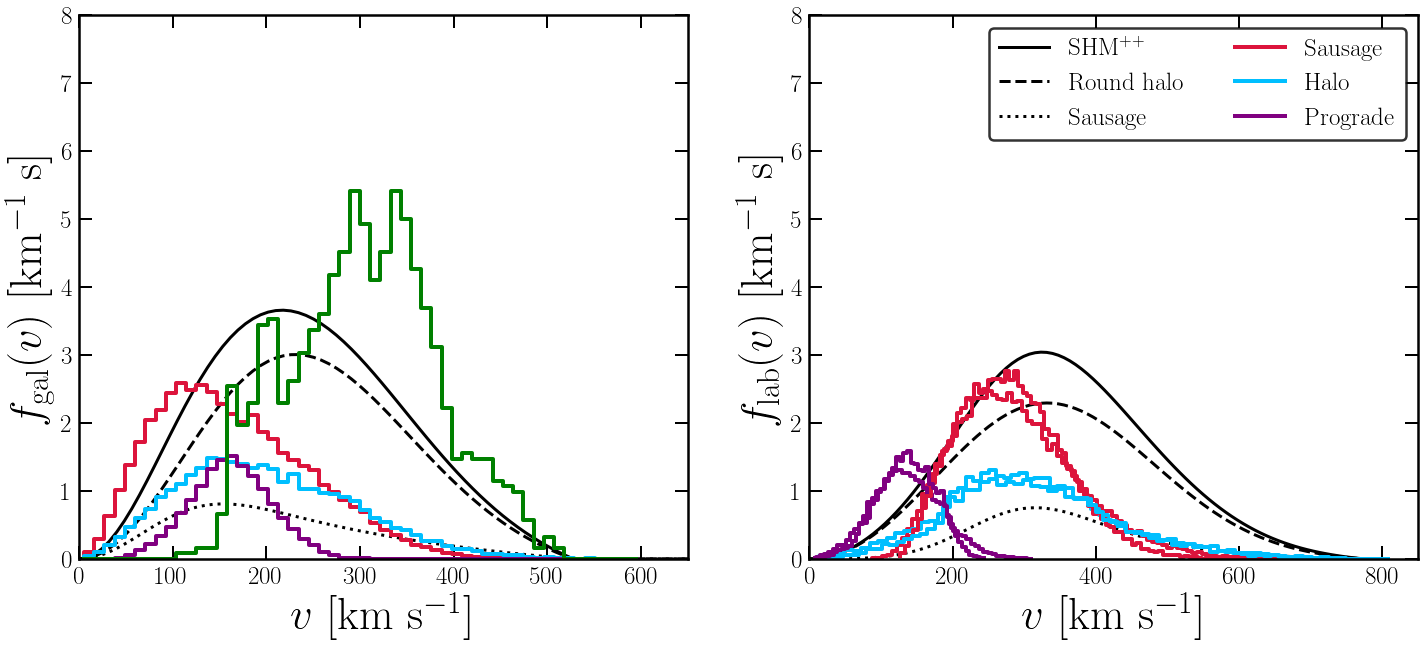

In [158]:
# Analytic distributions
v = linspace(0,800.0,100)
day = 67
v_lab = LabVelocitySimple(day)
eta = 0.2
SCO = True
v0 = SHMpp.RotationSpeed
v_esc = SHMpp.EscapeSpeed
sig_beta = SHMpp.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
fv_Iso_lab = SpeedDist_Triaxial(v,67,sig_iso,SmoothCutoff=SCO) # Galactic frame Halo
fv_Saus_lab = SpeedDist_Triaxial(v,67,sig_beta,SmoothCutoff=SCO) # Galactic frame Sausage
fv_Iso_gal = SpeedDist_Triaxial(v,67,sig_iso,SmoothCutoff=SCO,GalFrame=True) # Galactic frame Halo
fv_Saus_gal = SpeedDist_Triaxial(v,67,sig_beta,SmoothCutoff=SCO,GalFrame=True) # Galactic frame Sausage
fv0_lab = (1-eta)*fv_Iso_lab + eta*fv_Saus_lab
fv0_gal = (1-eta)*fv_Iso_gal + eta*fv_Saus_gal


# Speeds
def speeds_Gal(dfc):
    return sqrt((dfc.GalRVel)**2.0+(dfc.GalphiVel)**2.0+(dfc.GalzVel)**2.0)

def speeds_Lab_cyl(dfc):
    vphi = dfc.GalphiVel
    vrho = dfc.GalRVel
    vz = dfc.GalzVel
    return sqrt((vrho-v_lab[0])**2.0+(vphi-v_lab[1])**2.0+(vz-v_lab[2])**2.0)

def speeds_Lab_sph(dfc):
    x = dfc.GalRecX
    y = dfc.GalRecY
    z = dfc.GalRecZ
    vx = dfc.GalU
    vy = dfc.GalV
    vz = dfc.GalW
    R = sqrt(x**2.0+y**2.0+z**2.0)
    th = arccos(z/R)
    ph = arctan2(y,x)
    vR = sin(th)*cos(ph)*vx + sin(th)*sin(ph)*vy + cos(ph)*vz
    vth = cos(th)*cos(ph)*vx + cos(th)*sin(ph)*vy - sin(ph)*vz
    vph = -sin(ph)*vx + cos(ph)*vy
    return sqrt((vR-v_lab[0])**2.0+(vph-v_lab[1])**2.0+(vth-v_lab[2])**2.0)


vvS_lab_cyl = sqrt((df_S.GalRVel-v_lab[0])**2.0+(df_S.GalTVel-v_lab[1])**2.0+(df_S.GalzVel-v_lab[2])**2.0)
vvS_gal = sqrt((df_S.GalRVel)**2.0+(df_S.GalTVel)**2.0+(df_S.GalzVel)**2.0)


xlab1 = r"$v$ [km s$^{-1}$]"
ylab1 = r"$f_{\rm gal}(v)$ [km$^{-1}$ s]"
ylab2 = r"$f_{\rm lab}(v)$ [km$^{-1}$ s]"
fig,ax1,ax2 = MyDoublePlot(xlab1,ylab1,xlab1,ylab2,size_x=24,size_y=10,wspace=0.2)

nbins = 55
vmin = 0.0
vmax_lab = 800
vmax_gal = 600

alph = 0.5
col1 = 'crimson'
col2 = 'deepskyblue'
col3 = 'purple'
colS = 'green'


# Galactic frame
ax1.plot(v,1e3*fv0_gal,'k-',lw=3,label=r'SHM$^{++}$')
ax1.plot(v,1e3*(1-eta)*fv_Iso_gal,'k--',lw=3,label='Round halo')
ax1.plot(v,1e3*eta*fv_Saus_gal,'k:',lw=3,label='Sausage')
h_shards,vbins = histogram(vvS_gal,bins=nbins,normed=True,range=(vmin,vmax_gal))
vc = (vbins[1:]+vbins[0:-1])/2

h1,_ = histogram(speeds_Gal(df1),bins=nbins,normed=True,range=(vmin,vmax_gal))
h2,_ = histogram(speeds_Gal(df2),bins=nbins,normed=True,range=(vmin,vmax_gal))
h3,_ = histogram(speeds_Gal(df3),bins=nbins,normed=True,range=(vmin,vmax_gal))

#ax1.fill_between(vc,1e3*h1,y2=0,color=col1,lw=None,alpha=alph,step='pre',zorder=0,label=method1)
ax1.step(vc,1e3*h1*ws[0],'-',color=col1,lw=4,label='Sausage')

#ax1.fill_between(vc,1e3*h2,y2=0,color=col2,lw=None,alpha=alph,step='pre',zorder=0,label=method2)
ax1.step(vc,1e3*h2*ws[1],'-',color=col2,lw=4,label='Halo')

#ax1.fill_between(vc,1e3*h3,y2=0,color=col3,lw=None,alpha=alph,step='pre',zorder=0,label=method3)
ax1.step(vc,1e3*h3*ws[2],'-',color=col3,lw=4,label='Prograde')

ax1.step(vc,1e3*h_shards,'-',color=colS,lw=4,label='Shards stars')



# Lab frame
ax2.plot(v,1e3*fv0_lab,'k-',lw=3,label=r'SHM$^{++}$')
ax2.plot(v,1e3*(1-eta)*fv_Iso_lab,'k--',lw=3,label='Round halo')
ax2.plot(v,1e3*eta*fv_Saus_lab,'k:',lw=3,label='Sausage')


h1,v1 = histogram(speeds_Lab_sph(df1),bins='fd',normed=True)
h2,v2 = histogram(speeds_Lab_sph(df2),bins='fd',normed=True)
h3,v3 = histogram(speeds_Lab_sph(df3),bins='fd',normed=True)
ax2.step((v1[1:]+v1[0:-1])/2,1e3*h1*ws[0],'-',color=col1,lw=4,label='Sausage')
ax2.step((v2[1:]+v2[0:-1])/2,1e3*h2*ws[1],'-',color=col2,lw=4,label='Halo')
ax2.step((v3[1:]+v3[0:-1])/2,1e3*h3*ws[2],'-',color=col3,lw=4,label='Prograde')


h1,v1 = histogram(speeds_Lab_cyl(df1),bins='fd',normed=True)
h2,v2 = histogram(speeds_Lab_cyl(df2),bins='fd',normed=True)
h3,v3 = histogram(speeds_Lab_cyl(df3),bins='fd',normed=True)
ax2.step((v1[1:]+v1[0:-1])/2,1e3*h1*ws[0],'--',color=col1,lw=4)
ax2.step((v2[1:]+v2[0:-1])/2,1e3*h2*ws[1],'--',color=col2,lw=4)
ax2.step((v3[1:]+v3[0:-1])/2,1e3*h3*ws[2],'--',color=col3,lw=4)

#h_shards,vs = histogram(vvS_lab,bins='fd',normed=True)
#ax2.step((vs[1:]+vs[0:-1])/2,1e3*h_shards,'-',color=colS,lw=4,label='Shards stars')

# Legend lines
leg = ax2.legend(loc='upper right',fontsize=25,edgecolor='k',ncol=2)
leg.get_frame().set_linewidth(2.5)



# Limits
ax1.set_xlim([0,650])
ax1.set_ylim(bottom=0.0,top=8.)
ax2.set_xlim([0,850])
ax2.set_ylim(bottom=0.0,top=8.)


# Save
plt.show()
pltname = 'fv_3components'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')     

In [123]:
df.columns

Index([u'ra', u'dec', u'pmra', u'pmdec', u'pml', u'pmb', u'phot_g_mean_mag',
       u'l', u'b', u'psfmag_u', u'psfmagerr_u', u'psfmag_g', u'psfmagerr_g',
       u'psfmag_r', u'psfmagerr_r', u'psfmag_i', u'psfmagerr_i', u'psfmag_z',
       u'psfmagerr_z', u'hrv_e', u'hrv', u'logg', u'logg_e', u'teff',
       u'teff_e', u'feh', u'feh_e', u'helio_dist', u'X', u'Y', u'Z', u'GalR',
       u'Galphi', u'Galz', u'Galdist', u'GalRecX', u'GalRecY', u'GalRecZ',
       u'U', u'V', u'W', u'GalU', u'GalV', u'GalW', u'GalRVel', u'GalphiVel',
       u'GalzVel', u'JR', u'Jphi', u'Jz', u'E', u'apocentre', u'pericentre',
       u'eccent', u'zmax', u'orb_incl', u'orb_incl_deg'],
      dtype='object')

In [121]:
vR = df.GalRVel
vphi = df.GalphiVel
vz = df.

0         8.260187
1         9.222141
2         8.173773
3         9.494824
4         8.251199
5         8.800150
6         5.245403
7         8.137866
8         8.080522
9         9.358259
10        8.093268
11        9.031471
12        8.470210
13        9.058972
14        8.592392
15        8.664760
16        8.293170
17        8.550931
18        8.504412
19        8.565787
20        8.182032
21        8.276640
22        8.571209
23        7.041342
24        8.017067
25        8.464175
26        8.645173
27        8.152908
28        7.942062
29        8.187524
           ...    
65376     8.298975
65377     8.315402
65378     8.023679
65379     8.677808
65380     8.185328
65381     8.856785
65382     8.217971
65383     9.094571
65384     8.316110
65385     7.824887
65386     8.570815
65387     8.287995
65388     8.301335
65389     6.860779
65390     7.200255
65391    11.850633
65392     9.650096
65393     8.262703
65394     8.496486
65395    10.103581
65396    14.378767
65397     7.

In [146]:
x = df.GalRecX
y = df.GalRecY
z = df.GalRecZ
vx = df.GalU
vy = df.GalV
vz = df.GalW
R = sqrt(x**2.0+y**2.0+z**2.0)
th = arccos(z/R)
ph = arctan2(y,x)
vR = sin(th)*cos(ph)*vx + sin(th)*sin(ph)*vy + cos(ph)*vz
vth = cos(th)*cos(ph)*vx + cos(th)*sin(ph)*vy - sin(ph)*vz
vph = -sin(ph)*vx + cos(ph)*vy

vphi = df.GalphiVel

In [150]:
vph[100]

129.22267989050169

In [149]:
vphi[100]

129.22267988999999